# Instalação das bibliotecas

In [1]:
!pip install ipywidgets
!pip install pandas
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install torchvision
!pip install torch
!pip install kagglehub
!pip install kaggle
!pip install scikit-learn

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss  
from torchvision.datasets import ImageFolder
import sys

# Exploração de dados
- etapa para inspecionar visualmente os dados e garantir que o processo de carregamento e pré-processamento está funcionando como esperado antes de alimentar os dados a um modelo de aprendizado de máquina.

In [3]:
script_main_dir = os.getcwd()  # FIAP/src/
project_root_dir = os.path.join(script_main_dir, "..")  # FIAP/
path_main = os.path.join(project_root_dir, "dados", "processados")
path_main = os.path.normpath(path_main)
train_path = os.path.join(path_main, "train")
test_path = os.path.join(path_main, "test")
val_path = os.path.join(path_main, "valid")
print(f"Path Main: {path_main}")
print(f"Path train: {train_path}")
print(f"Path test: {test_path}")
print(f"Path valid: {val_path}")

Path Main: C:\Users\felip\FIAP\dados\processados
Path train: C:\Users\felip\FIAP\dados\processados\train
Path test: C:\Users\felip\FIAP\dados\processados\test
Path valid: C:\Users\felip\FIAP\dados\processados\valid


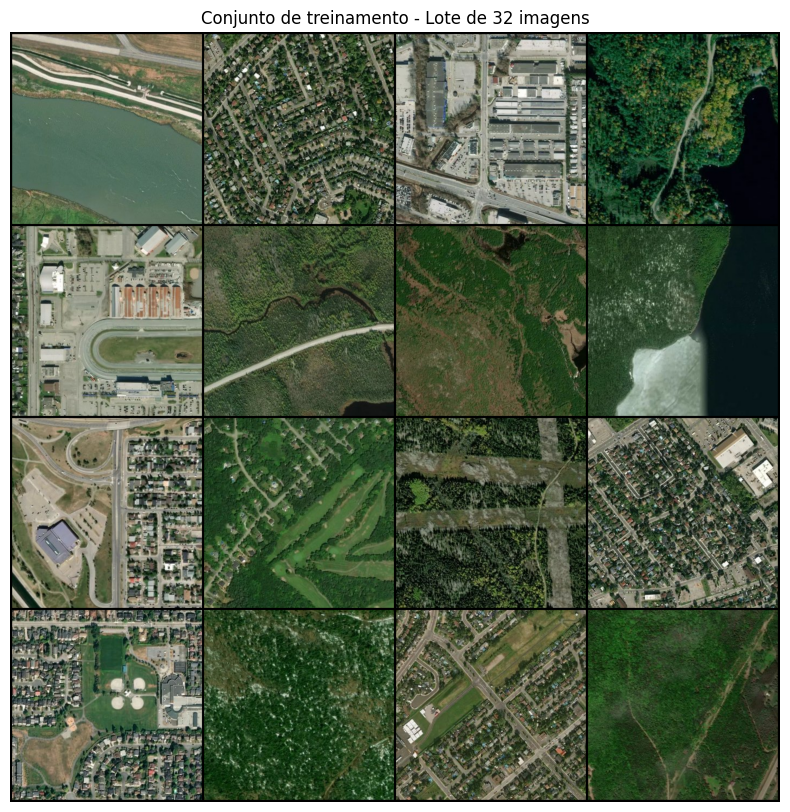

In [4]:
# ImageFolder - Classe de carregamento de dados das imagens onde cada sub classe
train_dataset = ImageFolder(root=train_path, transform=transforms.ToTensor())
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)

def show_image_grid(loader, n_images=32, nrow=8, title="Image Grid"):
    # Obter um lote de imagens
    batch = next(iter(loader))
    transform=transforms.ToTensor()
    # Extrair imagens e rótulos
    images, labels = batch

    # Limitar o número de imagens às n_images especificadas
    images = images[:n_images]

    # Grade de imagens
    grid_img = torchvision.utils.make_grid(images, nrow=nrow, padding=4)

    # Converta a imagem da grade para numpy para exibição
    grid_img = grid_img.numpy().transpose(1, 2, 0)

    # Exibir a grade de imagens
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Exibir uma grade de 32 imagens do conjunto de treinamento
show_image_grid(train_loader, n_images=16, nrow=4, title="Conjunto de treinamento - Lote de 32 imagens")

# Processamento de dados
As funções fornecem um conjunto útil de ferramentas para explorar um diretório de dados, especialmente para conjuntos de dados de imagens, e prepará-los em um formato tabular (DataFrame)

In [5]:
#percorrer recursivamente estrutura de diretórios
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"Há  {len(dirnames)} diretórios e {len(filenames)} imagens em '{dirpath}'.")
    print()

def get_filetypes(filepath):
    exts = set(os.path.splitext(f)[1] for dir,dirs,files in os.walk(filepath) for f in files)
    print("Extensões de arquivo no diretório: ", exts)
    return exts

def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [6]:
train_df = process_img(train_path)
val_df = process_img(val_path)
test_df = process_img(test_path)

# Visualização das dimensões das imagens

In [7]:
walk_through_dir("/kaggle/input/wildfire-prediction-dataset")

img = cv2.imread(train_df.iloc[0].Filepath)
INPUT_SHAPE = img.shape
print(f"pixels de altura: {INPUT_SHAPE[0]} /  pixels de largura:{INPUT_SHAPE[1]} / canais de cor: :{INPUT_SHAPE[2]}")


pixels de altura: 350 /  pixels de largura:350 / canais de cor: :3


# Verificação de imagens e rótulos
Forma de verificar a qualidade e a variedade das imagens no seu conjunto de treinamento e confirmar se os rótulos estão corretos

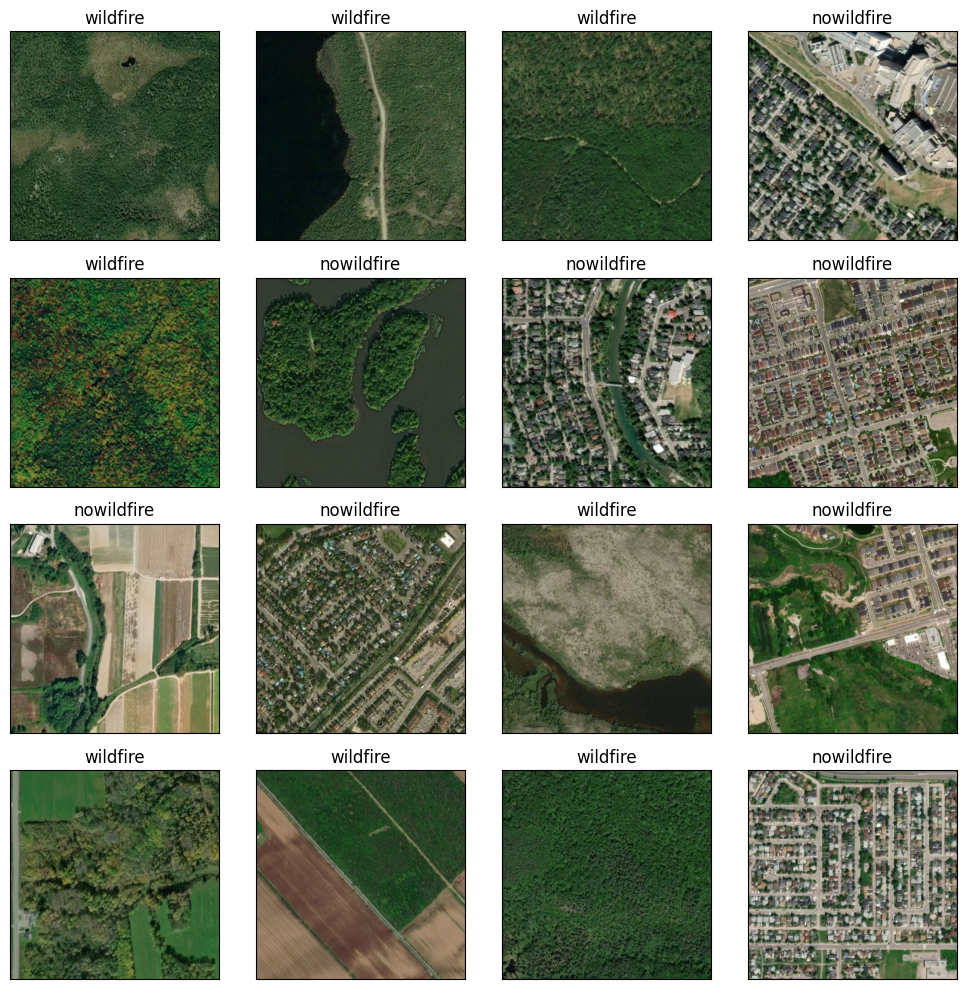

In [8]:
def show_image_sample(df):
    random_data = df.sample(n=16)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(random_data.iloc[i].Filepath))
        ax.set_title(random_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()

show_image_sample(train_df)

# Preparar Imagens
Preparar dados de imagem para serem usados em um modelo de aprendizado

In [9]:
train_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()


])
testval_transform=transforms.Compose([
    transforms.Resize((256,256)),
     transforms.ToTensor()
])

In [10]:
train_dataset = ImageFolder(root=train_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_path, transform=testval_transform)
valid_dataset = ImageFolder(
    root=val_path,
    transform=testval_transform,
)

In [11]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)

# Selecionando o modelo de IA e o tipo de plataforma que vai ser executado
- O modelo será treinado no modelo ResNet-18, pois:
    - A ResNet-18 é frequentemente considerada uma opção vantajosa devido ao seu equilíbrio entre capacidade de desempenho e exigência computacional.
    - Suas 18 camadas permitem que o modelo aprenda representações complexas dos dados de imagem. A arquitetura da ResNet-18 incorpora as chamadas "conexões residuais", um mecanismo que facilita o treinamento eficaz dessas múltiplas camadas, o que é fundamental para alcançar boa precisão nas tarefas.
    - Adicionalmente, a disponibilidade de modelos ResNet-18 pré-treinados é um fator prático importante. Utilizar esses pesos iniciais pode acelerar o desenvolvimento do projeto e levar a resultados superiores, especialmente quando o volume de dados para treinamento específico é limitado.

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) 
if torch.cuda.is_available():
    device_str = 'cuda'
elif sys.platform == 'darwin' and torch.backends.mps.is_available():
    # Verifica se o SO é macOS ('darwin') e se o backend MPS está disponível
    device_str = 'mps'
else:
    device_str = 'cpu'
device = torch.device(device_str)
print(device)
model.to(device)
# definir otimizador e função de perda
optimizer=Adam(model.parameters(),lr=0.001)
loss_fn=CrossEntropyLoss()

cuda


# Loop de treinamento

In [15]:
num_epochs = 10
num_classes = 2
train_losses = []
val_losses = []
val_accuracies = []

ImageFile.LOAD_TRUNCATED_IMAGES = True
model.train()  # Define o modelo para o modo de treinamento
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Migrar para GPU/CPU

        optimizer.zero_grad()  # Zerar os gradientes
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Fase de avaliação
    model.eval()  # Defina o modelo para o modo de avaliação
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)  # Migrar para GPU/CPU
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, y_pred = torch.max(outputs, 1) 
            correct += (y_pred == labels).sum().item()  # Contar as previsões corretas

    val_losses.append(val_loss / len(valid_loader))
    val_accuracy = correct / len(valid_dataset)
    val_accuracies.append(val_accuracy)

    print(f"Época [{epoch+1}/{num_epochs}] - "
          f"Perda de treinamento: {train_loss:.4f}, "
          f"Validação perdida: {val_loss/len(valid_loader):.4f}, "
          f"Precisão de Validação: {val_accuracy:.4f}")

Época [1/10] - Perda de treinamento: 0.1832, Validação perdida: 1.3684, Precisão de Validação: 0.6565
Época [2/10] - Perda de treinamento: 0.3493, Validação perdida: 0.2161, Precisão de Validação: 0.9248
Época [3/10] - Perda de treinamento: 0.2266, Validação perdida: 0.1702, Precisão de Validação: 0.9327
Época [4/10] - Perda de treinamento: 0.1858, Validação perdida: 0.1348, Precisão de Validação: 0.9498
Época [5/10] - Perda de treinamento: 0.1669, Validação perdida: 0.1301, Precisão de Validação: 0.9508
Época [6/10] - Perda de treinamento: 0.1544, Validação perdida: 0.1378, Precisão de Validação: 0.9457
Época [7/10] - Perda de treinamento: 0.1457, Validação perdida: 0.1865, Precisão de Validação: 0.9265
Época [8/10] - Perda de treinamento: 0.1350, Validação perdida: 0.1489, Precisão de Validação: 0.9414
Época [9/10] - Perda de treinamento: 0.1280, Validação perdida: 0.1272, Precisão de Validação: 0.9532
Época [10/10] - Perda de treinamento: 0.1199, Validação perdida: 0.0972, Precisão 

# Performance do modelo
- Dashboard abaixo mostra a precisão do treinamento

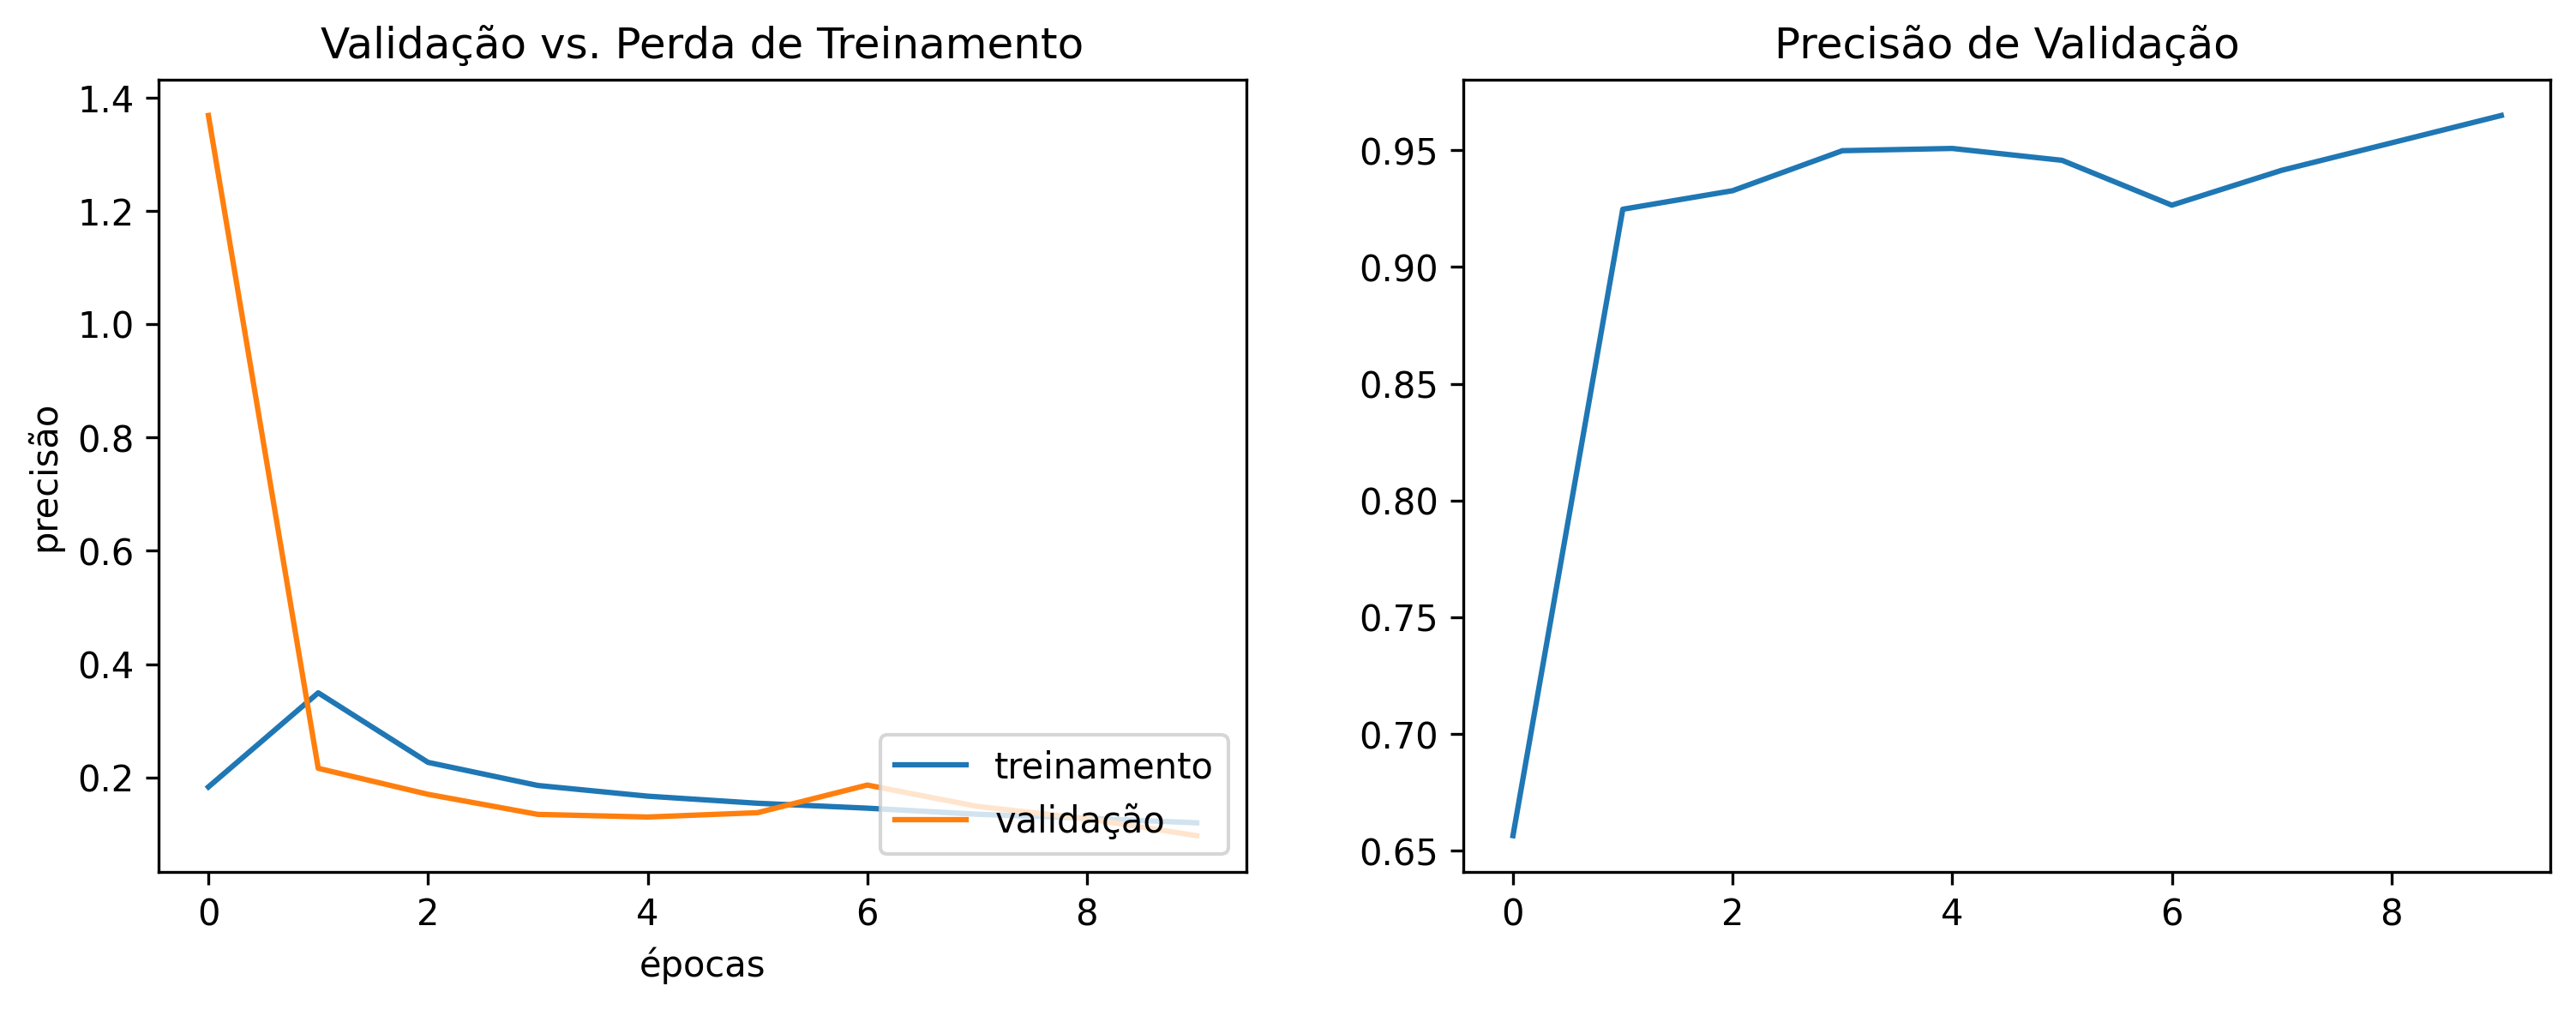

In [16]:
plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.title('Validação vs. Perda de Treinamento')
plt.plot(train_losses, label = 'treinamento')
plt.plot(val_losses, label = 'validação')

plt.legend(loc = 'lower right')
plt.xlabel('épocas')
plt.ylabel('precisão')

plt.subplot(1,2,2)
plt.title('Precisão de Validação')
plt.plot(val_accuracies, label = 'val_accuracy')

# Mostrar report
plt.show()

# Avaliação do Modelo

In [17]:
all_labels=[]
all_preds=[]
model=model.to(device)
model.eval()
total=0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Teste de precisão: {accuracy:.2f}")


Teste de precisão: 1.94


# Revocação 

In [18]:
recall = recall_score(all_labels, all_preds, pos_label=1)
print(f"Revocação (Recall): {recall:.4f}")

Revocação (Recall): 0.9693


#  F1-Score

In [19]:
f1 = f1_score(all_labels, all_preds, pos_label=1)
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.9749


# Especificidade 

In [20]:
Specificity = recall_score(all_labels, all_preds, pos_label=0)
print(f"Especificidade: {Specificity:.4f}")

Especificidade: 0.9762


# Matriz de Confusão 

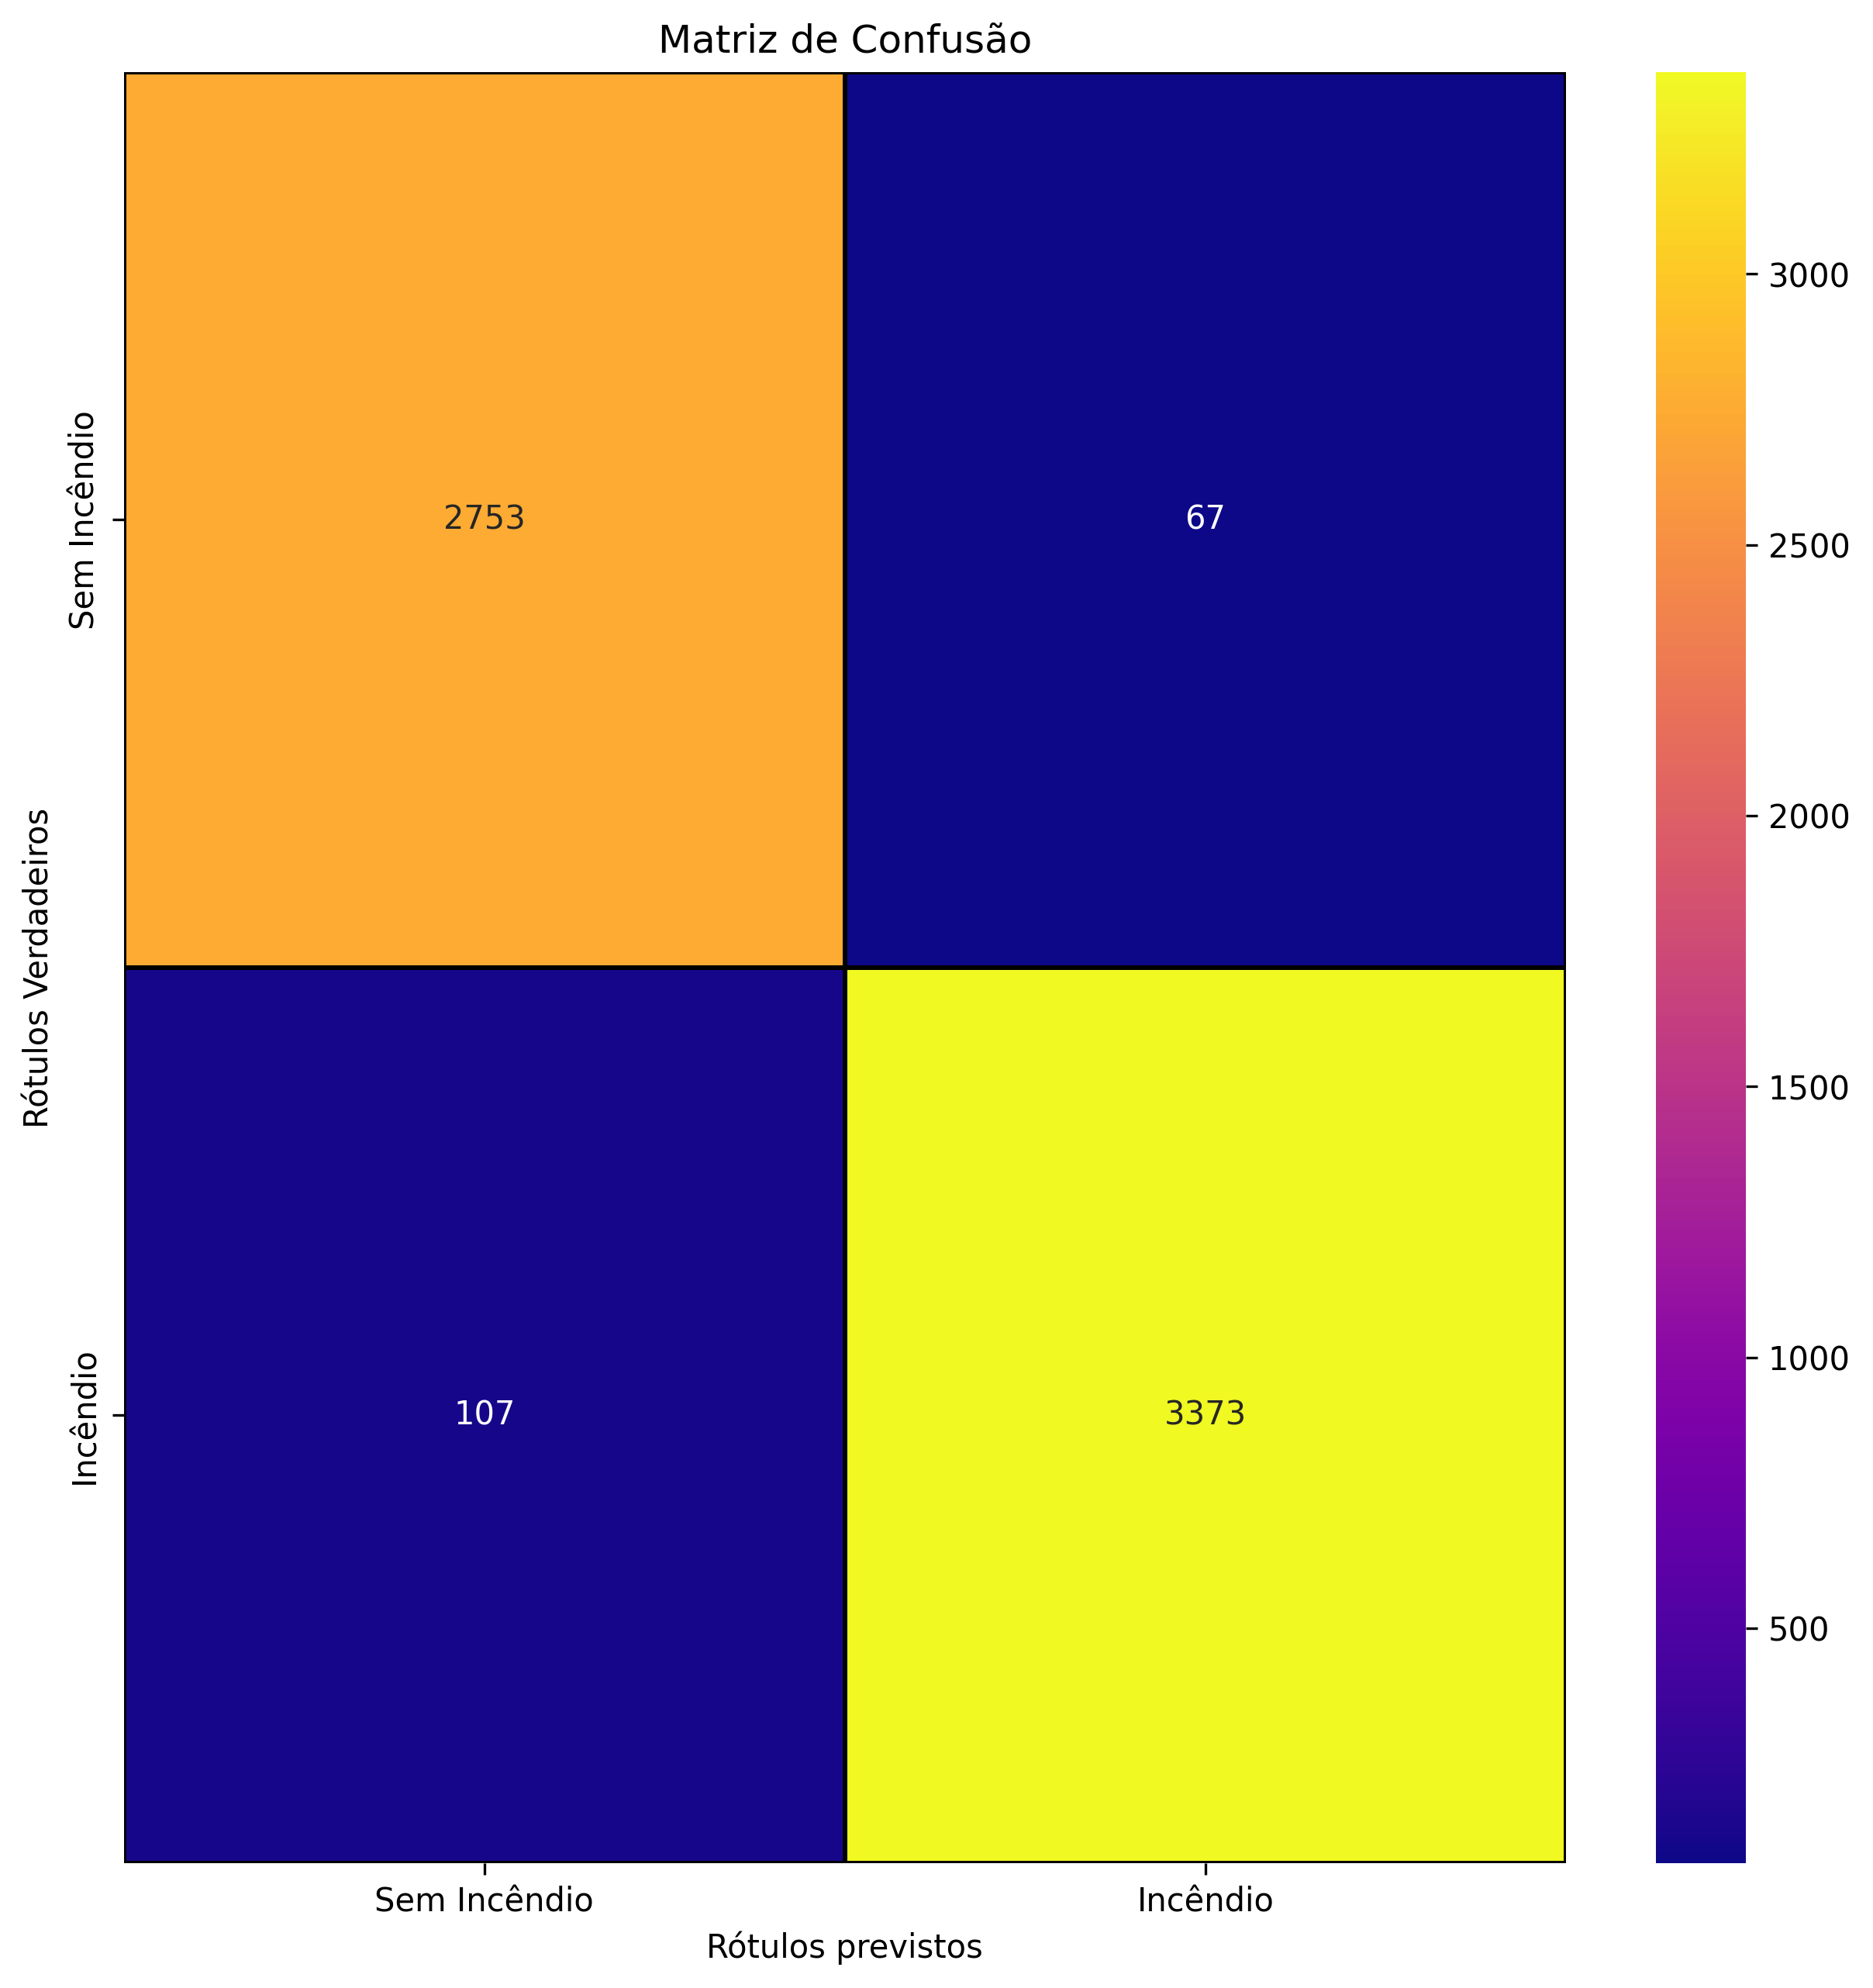

In [21]:
classes=['Sem Incêndio','Incêndio']

cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap="plasma"
            , linewidths=1,
            linecolor="black", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulos previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()



## Get Predictions!

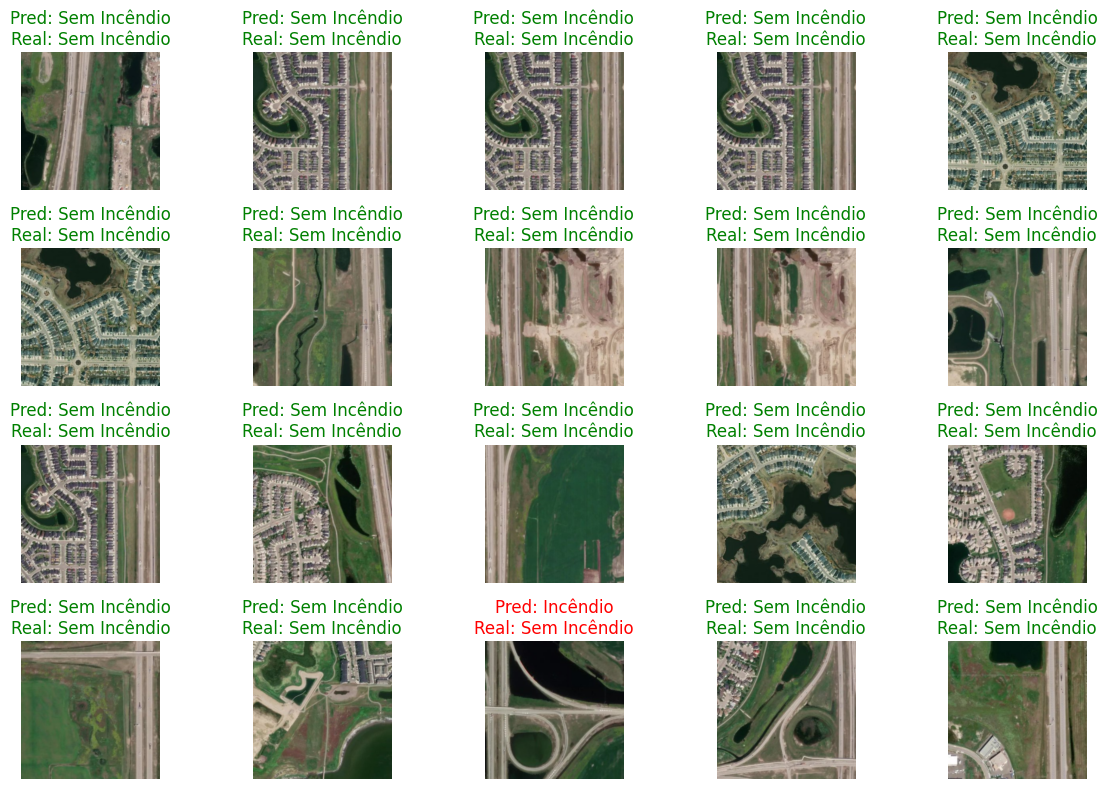

In [29]:
# Defina o número de imagens, linhas e colunas
num_images = 20
num_rows = 4
num_cols = 5

# Criar figura
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Defina o modelo para o modo de avaliação
model=model.to(device)
model.eval()

# Sem computação de gradiente
with torch.no_grad():
    # Faça um loop sobre o número de imagens que queremos exibir
    for i in range(num_images):
        img, label = next(iter(test_loader)) 
        img, label=img.to(device),label.to(device)
        # Selecione uma imagem aleatória do lote
        index = np.random.randint(0, len(img))
        img_to_show = img[index]
        label_to_show = label[index]

        # Certifique-se de que a imagem esteja na CPU e remova a dimensão do lote
        img_to_show = img_to_show.to('cpu')
        img_to_show = img_to_show.permute(1, 2, 0) 

        # Faça previsões
        outputs = model(img[index].unsqueeze(0))
        _, predicted_index = torch.max(outputs, 1)
        color = 'green' if predicted_index.item() == label_to_show.item() else 'red'


        # Exibir a imagem
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img_to_show, cmap='gray')
        ax.set_title(f"Pred: {classes[predicted_index.item()]}\nReal: {classes[label_to_show.item()]}", color=color)
        ax.axis('off') 

plt.tight_layout()
plt.show()

# Exportação do Modelo

In [24]:
# Define o caminho onde os pesos serão salvos
PATH_PESOS = "modelo_incendio.pth"
torch.save(model.state_dict(), PATH_PESOS)
print(f"Pesos do modelo salvos em: {PATH_PESOS}")

Pesos do modelo salvos em: modelo_incendio.pth
